In [289]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [290]:
def f(x):
    return x**2 +3*x + 2

In [291]:
f(2)

12

In [292]:
xs = np.arange(-10, 10, 0.25)
ys = f(xs)
ys

array([ 72.    ,  67.8125,  63.75  ,  59.8125,  56.    ,  52.3125,
        48.75  ,  45.3125,  42.    ,  38.8125,  35.75  ,  32.8125,
        30.    ,  27.3125,  24.75  ,  22.3125,  20.    ,  17.8125,
        15.75  ,  13.8125,  12.    ,  10.3125,   8.75  ,   7.3125,
         6.    ,   4.8125,   3.75  ,   2.8125,   2.    ,   1.3125,
         0.75  ,   0.3125,   0.    ,  -0.1875,  -0.25  ,  -0.1875,
         0.    ,   0.3125,   0.75  ,   1.3125,   2.    ,   2.8125,
         3.75  ,   4.8125,   6.    ,   7.3125,   8.75  ,  10.3125,
        12.    ,  13.8125,  15.75  ,  17.8125,  20.    ,  22.3125,
        24.75  ,  27.3125,  30.    ,  32.8125,  35.75  ,  38.8125,
        42.    ,  45.3125,  48.75  ,  52.3125,  56.    ,  59.8125,
        63.75  ,  67.8125,  72.    ,  76.3125,  80.75  ,  85.3125,
        90.    ,  94.8125,  99.75  , 104.8125, 110.    , 115.3125,
       120.75  , 126.3125])

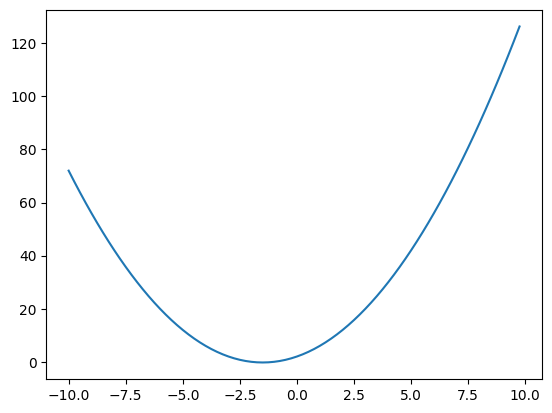

In [293]:
plt.plot(xs, ys)

## Derivates

In [294]:
h = 0.0001
def derivative(x):
    return (f(x+h)-f(x))/h

In [295]:
derivative(2) # 2x + 3 = 2*2 + 3 = 7

7.000100000027487

In [296]:
derivative(3) # 2x + 3 = 2*3 + 3 = 9

9.000100000022826

## Complex parameter derivation (partial derivatives)

In [297]:
def pf(x,y,z):
    return x*y+z

In [298]:
def der(x,y,z,dx,dy,dz):
    return (pf(x+dx,y+dy,z+dz)-pf(x,y,z))/(dx+dy+dz)

In [299]:
der(2,3,4,h,0,0) # 3 (d(d1)/dx) = (y) = 3

3.000000000010772

In [300]:
der(2,3,4,0,h,0) # 2 (d(d1)/dy=x=2)

1.9999999999953388

In [301]:
der(2,3,4,0,0,h) # 1 (d(d1)/dz=1)

0.9999999999976694

## Start of Understanding classes and objects

In [302]:
class Value:

    def __init__(self,data,_children=(),_op=(),label=''): # _children is a tuple
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0.0
    
    def __repr__(self):
        return f"Value (data={self.data} label={self.label})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other), "+")
        def _backward():
            self.grad =  1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other), "*")
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    def tanh(self):
        out = Value(math.tanh(self.data), (self,), "tanh")
        def _backward():
            self.grad = (1.0 - (out.data ** 2)) * out.grad
        out._backward = _backward
        return out
    def backward(self):
        # self.grad = 1.0
        # visited = set()
        # def _backward(v):
        #     if v not in visited:
        #         visited.add(v)
        #         v._backward()
        #         [ _backward(child) for child in v._prev ]
        # _backward(self)
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                [build_topo(child) for child in v._prev]
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

In [303]:
Value(3)  # Python internally calls obj.__repr__() where obj = Value(3)

Value (data=3 label=)

In [304]:
Value(3) + Value(4) # Python internally calls obj.__add__(other) where obj = Value(3) and other = Value(4)

Value (data=7 label=)

In [305]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c =  Value(10.0,label='c')
e = a*b # Python internally calls obj.__mul__(other) where obj = Value(3) and other = Value(4)
e.label = 'e'
d = c +e # Python internally calls obj.__mul__(other) where obj = Value(3) and other = Value(4)
d.label = 'd'
f = Value(-2.0,label='f')
L = d * f # Python internally calls obj.__mul__(other) where obj = Value(3) and other = Value(4)
L.label = 'L'

In [306]:
e._prev

{Value (data=-3.0 label=b), Value (data=2.0 label=a)}

In [307]:
e.data

-6.0

In [308]:
e.label

'e'

## Showcase all operation in Graphs

In [309]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % ( n.label,n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

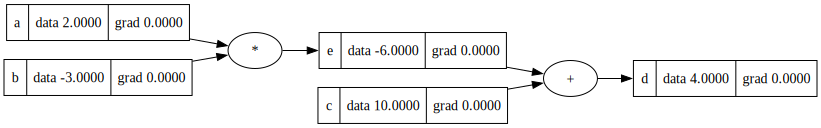

In [310]:
draw_dot(d)

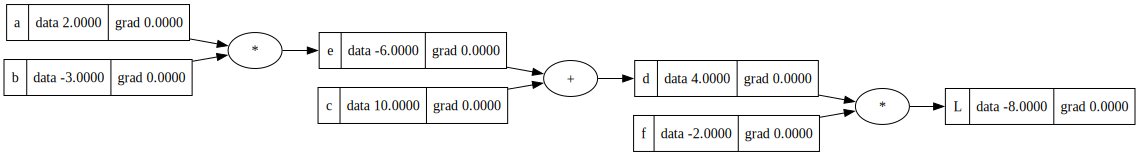

In [311]:
draw_dot(L)

## Backpropogation

In [312]:
# def backward(root):
#   # perform a backward pass on the graph
#   root.grad = 1.0
#   visited = set()
#   def backward_dfs(v):
#     if v in visited:
#       return
#     visited.add(v)
#     for child in v._prev:
#       # apply the chain rule to get the gradient of the child with respect to this node
#       child.grad += v.grad * derivative(child.data)
#       backward_dfs(child)
#   backward_dfs(root)

# backward(L)

In [313]:
e.data

-6.0

In [314]:
def fnc(da,db,dc,dd,de,df,dL):
    a = Value(2+da,label='a')
    b = Value(-3+db,label='b')
    c =  Value(10+dc,label='c')
    e = a*b
    e.data += de
    e.label = 'e'
    d = c +e
    d.data += dd
    d.label = 'd'
    f = Value(-2+df,label='f')
    L = d * f
    L.label = 'L'
    L.data += dL
    return L
fnc(0,0,0,0,0,0,0).data

-8

In [315]:
dL = (fnc(0,0,0,0,0,0,h).data - L.data)/h
L.grad = dL
L.grad

0.9999999999976694

In [316]:
df = (fnc(0,0,0,0,0,h,0).data - L.data)/h
f.grad = df
f.grad

3.9999999999995595

In [317]:
de = (fnc(0,0,0,0,h,0,0).data - L.data)/h
e.grad = de
e.grad

-1.9999999999953388

In [318]:
dd = (fnc(0,0,0,h,0,0,0).data - L.data)/h
d.grad = dd
d.grad

-1.9999999999953388

In [319]:
dc = (fnc(0,0,h,0,0,0,0).data - L.data)/h
c.grad = dc
c.grad

-1.9999999999953388

In [320]:
db = (fnc(0,h,0,0,0,0,0).data - L.data)/h
b.grad = db
b.grad

-4.000000000008441

In [321]:
da = (fnc(h,0,0,0,0,0,0).data - L.data)/h
a.grad = da
a.grad

6.000000000021544

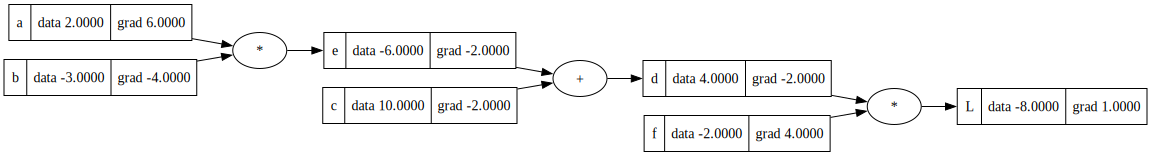

In [322]:
draw_dot(L)

In [323]:
def forward_pass(step):
    a.data += step * a.grad
    b.data += step * b.grad
    c.data += step * c.grad
    f.data += step * f.grad

    e = a*b
    d = c + e
    L = d * f
    return L.data

In [324]:
forward_pass(0.01)

-7.286495999998483

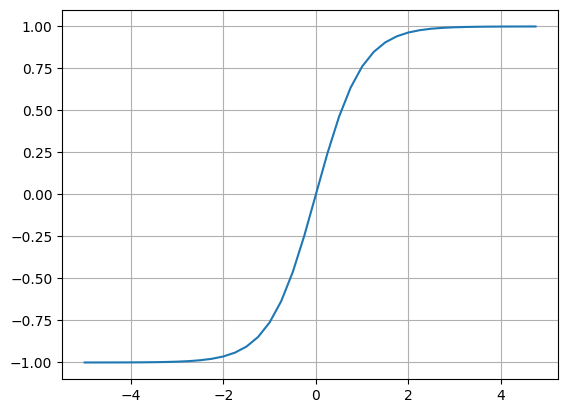

In [325]:
plt.plot(np.arange(-5,5,0.25),np.tanh(np.arange(-5,5,0.25))); plt.grid()

## Backward Propogation with neuron

In [326]:
x1 = Value(2.0,label='x1')
w1 = Value(-3.0,label='w1')
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2 = Value(0.0,label='x2')
w2 = Value(1.0,label='w2')
x2w2 = x2*w2
x2w2.label = 'x2w2'
b = Value(6.8813735870195432,label='b')
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1+x2w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'


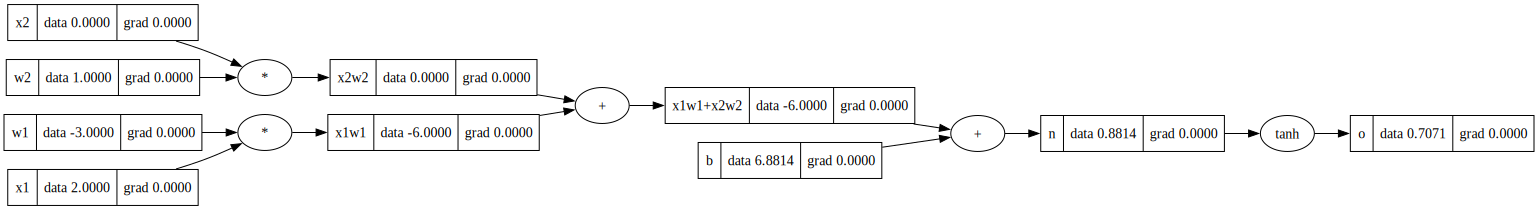

In [327]:
draw_dot(o)

In [328]:
o.grad = 1.0

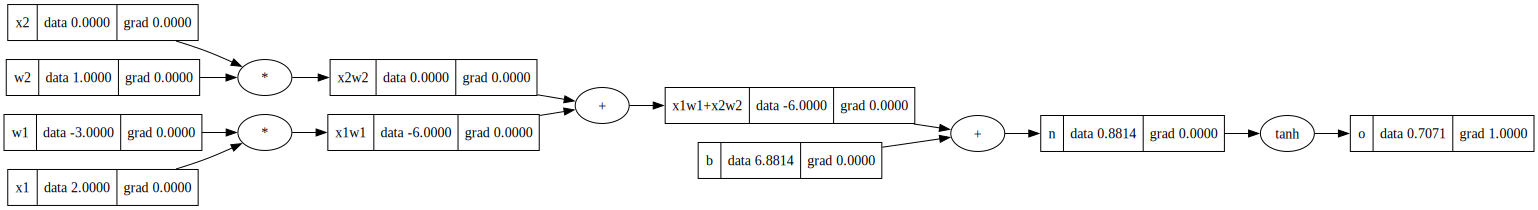

In [329]:
draw_dot(o)

In [330]:
o._backward()

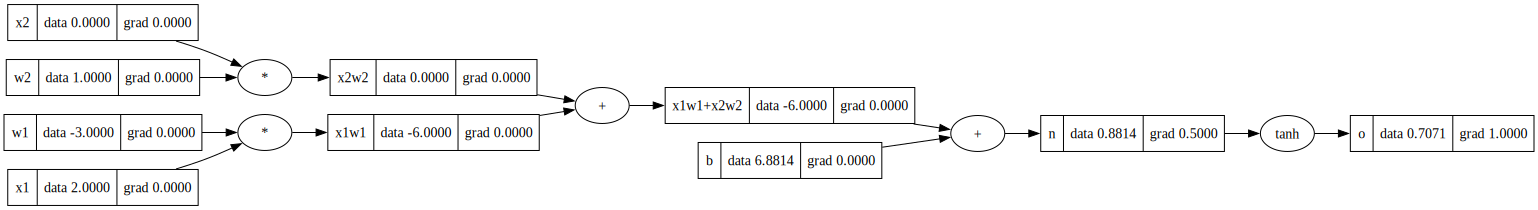

In [331]:
draw_dot(o)

In [332]:
n._backward()

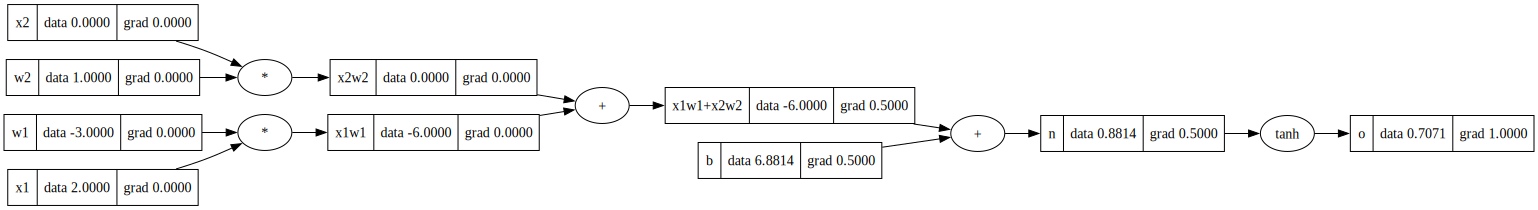

In [333]:
draw_dot(o)

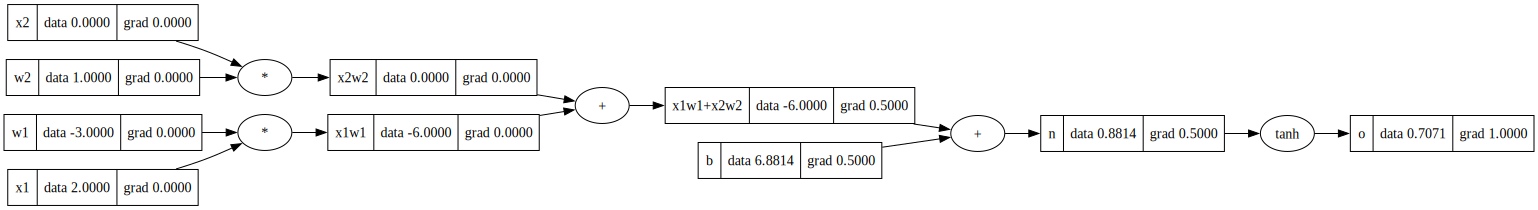

In [334]:
b._backward()
draw_dot(o)

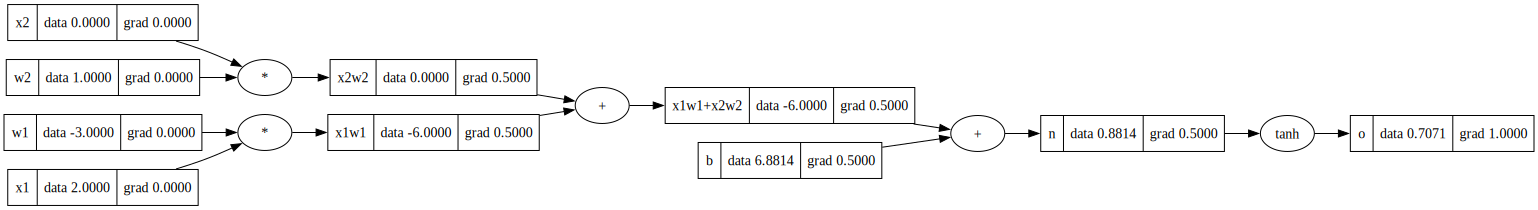

In [335]:
x1w1x2w2._backward()
draw_dot(o)

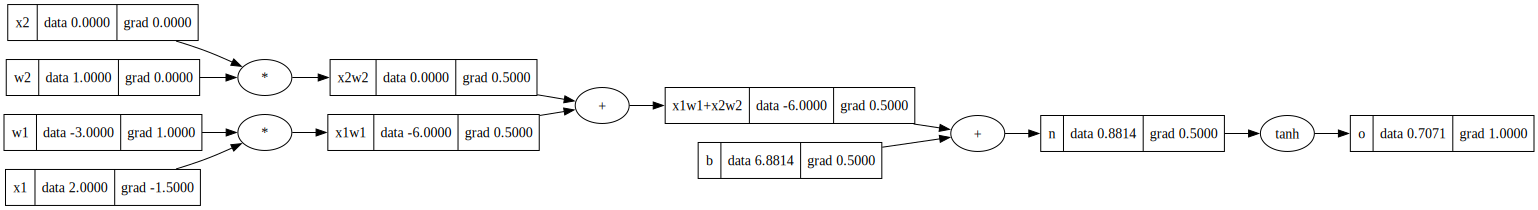

In [336]:
x1w1._backward()
draw_dot(o)

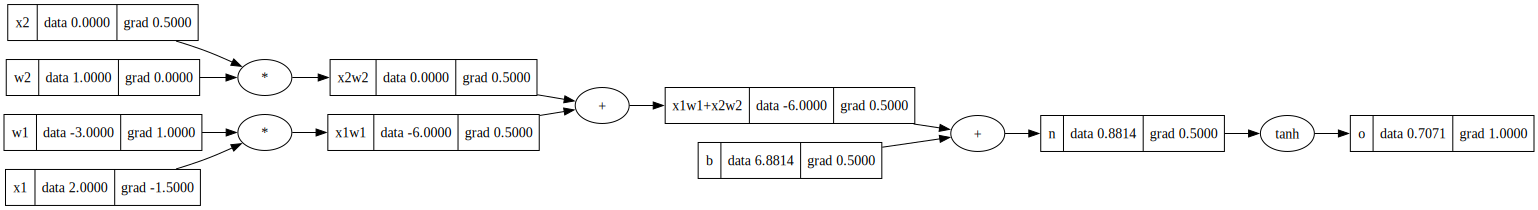

In [337]:
x2w2._backward()
draw_dot(o)

In [338]:
topo_order = []
visited = set()
def topological_sort(v):
    if v not in visited:
        visited.add(v)
    for child in v._prev:
        topological_sort(child)
    topo_order.append(v)
topological_sort(o)
topo_order

[Value (data=6.881373587019543 label=b),
 Value (data=1.0 label=w2),
 Value (data=0.0 label=x2),
 Value (data=0.0 label=x2w2),
 Value (data=-3.0 label=w1),
 Value (data=2.0 label=x1),
 Value (data=-6.0 label=x1w1),
 Value (data=-6.0 label=x1w1+x2w2),
 Value (data=0.8813735870195432 label=n),
 Value (data=0.7071067811865476 label=o)]

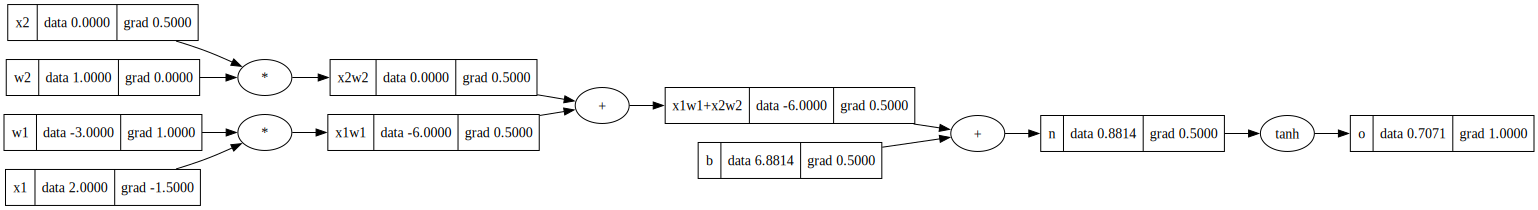

In [339]:
o.backward()
draw_dot(o)